# Create a voronoi for each FSP maps type

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from iso3166 import countries
import matplotlib.pyplot as plt
%matplotlib inline 
# The shapely.ops module has a cascaded_union that finds the cumulative union of many objects
from shapely.ops import cascaded_union

### Read country maps

In [2]:
#India
indMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_IND.shp')

# Get Uttar Pradesh and Bihar states
indMapStates = indMap[(indMap['NAME_1'] == 'Uttar Pradesh') | (indMap['NAME_1'] == 'Bihar')]

#Kenya
kenMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_KEN.shp')

#Uganda
ugaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_UGA.shp')

#Bangladesh
bgdMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_BGD.shp')

#Nigeria
ngaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_NGA.shp')

#Tanzania
tzaMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_TZA.shp')

#Lesotho
lsoMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_LSO.shp')

#Haiti
htiMap = gpd.read_file('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/gadm36_shp/gadm36_HTI.shp')

Get the boundary of each country

In [3]:
indBoundary = gpd.GeoSeries(cascaded_union(indMapStates['geometry']))
indBoundary = gpd.GeoDataFrame(indBoundary).rename(columns={0: 'geometry'})
indBoundary['country'] = 'India'
indBoundary['iso'] = 'IND'

kenBoundary = gpd.GeoSeries(cascaded_union(kenMap['geometry']))
kenBoundary = gpd.GeoDataFrame(kenBoundary).rename(columns={0: 'geometry'})
kenBoundary['country'] = 'Kenya'
kenBoundary['iso'] = 'KEN'

ugaBoundary = gpd.GeoSeries(cascaded_union(ugaMap['geometry']))
ugaBoundary = gpd.GeoDataFrame(ugaBoundary).rename(columns={0: 'geometry'})
ugaBoundary['country'] = 'Uganda'
ugaBoundary['iso'] = 'UGA'

bgdBoundary = gpd.GeoSeries(cascaded_union(bgdMap['geometry']))
bgdBoundary = gpd.GeoDataFrame(bgdBoundary).rename(columns={0: 'geometry'})
bgdBoundary['country'] = 'Bangladesh'
bgdBoundary['iso'] = 'BGD'

ngaBoundary = gpd.GeoSeries(cascaded_union(ngaMap['geometry']))
ngaBoundary = gpd.GeoDataFrame(ngaBoundary).rename(columns={0: 'geometry'})
ngaBoundary['country'] = 'Nigeria'
ngaBoundary['iso'] = 'NGA'

tzaBoundary = gpd.GeoSeries(cascaded_union(tzaMap['geometry']))
tzaBoundary = gpd.GeoDataFrame(tzaBoundary).rename(columns={0: 'geometry'})
tzaBoundary['country'] = 'Tanzania'
tzaBoundary['iso'] = 'TZA'

lsoBoundary = gpd.GeoSeries(cascaded_union(lsoMap['geometry']))
lsoBoundary = gpd.GeoDataFrame(lsoBoundary).rename(columns={0: 'geometry'})
lsoBoundary['country'] = 'Lesotho'
lsoBoundary['iso'] = 'LSO'

htiBoundary = gpd.GeoSeries(cascaded_union(htiMap['geometry']))
htiBoundary = gpd.GeoDataFrame(htiBoundary).rename(columns={0: 'geometry'})
htiBoundary['country'] = 'Haiti'
htiBoundary['iso'] = 'HTI'

boundaries = gpd.GeoDataFrame(pd.concat([indBoundary,kenBoundary,ugaBoundary,bgdBoundary,ngaBoundary,tzaBoundary,lsoBoundary, htiBoundary]))

In [4]:
boundaries

,geometry,country,iso
0,"(POLYGON ((88.10543060000001 26.53940773, 88.1...",India,IND
0,"(POLYGON ((39.37625122 -4.71569395, 39.3762512...",Kenya,KEN
0,"POLYGON ((30.21068954 -1.27639353, 30.20890808...",Uganda,UGA
0,"(POLYGON ((91.90669250000001 21.72977448, 91.9...",Bangladesh,BGD
0,"(POLYGON ((4.93763781 5.93624878, 4.93763781 5...",Nigeria,NGA
0,"(POLYGON ((40.40208435 -10.42291737, 40.402084...",Tanzania,TZA
0,POLYGON ((27.75421905517584 -30.60573959350586...,Lesotho,LSO
0,"(POLYGON ((-73.00517273 18.18572044, -73.00680...",Haiti,HTI


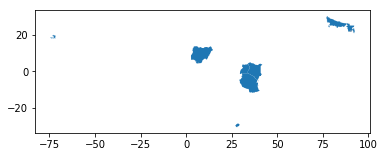

In [5]:
boundaries.plot()

### Voronoi tessellation finite_polygons
Built a Voronoi tessellation from points

In [6]:
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point

In [7]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [8]:
def voronoi_tesellation_box(boundary,lng,lat):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    boundary : GeoDataFrame, 
        Geometry of the country.
    lng : GeoSeries, 
        Longitud values of points. 
    lat : GeoSeries, 
        Longitud values of points. 
    Returns
    -------
    voronoid : GeaoDataFrames
        Geometries of Voronoi regions.
    """
    # array with points coordinates
    points = np.zeros((lng.shape[0],2))
    points[:,0] = lng
    points[:,1] = lat

    # compute Voronoi tesselation
    vor = Voronoi(points)
    
    # Reconstruct infinite voronoi regions in a 2D diagram to finite regions.
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # build box from country boundary
    xmin = boundary.bounds.minx[0]
    xmax = boundary.bounds.maxx[0]
    ymin = boundary.bounds.miny[0]
    ymax = boundary.bounds.maxy[0]

    box = Polygon([[xmin, ymin], [xmin, ymax], [xmax, ymax], [xmax, ymin]])

    voronoid = [] 
    for region in regions:
        polygon = vertices[region]
        # Clipping polygon
        poly = Polygon(polygon)
        voronoid.append(poly.intersection(box))
        
    voronoid = gpd.GeoDataFrame(geometry = voronoid)
    
    vor_lng = vor.points[:,0]
    vor_lat = vor.points[:,1]
    
    voronoid['lng'] = vor_lng
    voronoid['lat'] = vor_lat
    
    return voronoid    

Intersect voronoid with boundary

In [9]:
def spatial_overlays(df1, df2):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)

    # Spatial Index to create intersections
    spatial_index = df2.sindex
    df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
    df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
    pairs = df1['histreg'].to_dict()
    nei = []
    for i,j in pairs.items():
        for k in j:
            nei.append([i,k])
        
    pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
    pairs = pairs.merge(df1, left_on='idx1', right_index=True)
    pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
    pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
    pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
    cols = pairs.columns.tolist()
    cols.remove('geometry_1')
    cols.remove('geometry_2')
    cols.remove('histreg')
    cols.remove('bbox')
    cols.remove('Intersection')
    dfinter = pairs[cols+['Intersection']].copy()
    dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
    dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
    dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
    dfinter.drop(['idx1','idx2'], axis=1, inplace=True)
    return dfinter

Intersect voronoid with boundary

In [10]:
def spatial_overlays(df1, df2):
    '''Compute overlay intersection of two 
        GeoPandasDataFrames df1 and df2
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)

    # Spatial Index to create intersections
    spatial_index = df2.sindex
    df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
    df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
    pairs = df1['histreg'].to_dict()
    nei = []
    for i,j in pairs.items():
        for k in j:
            nei.append([i,k])
        
    pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
    pairs = pairs.merge(df1, left_on='idx1', right_index=True)
    pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
    pairs['Intersection'] = pairs.apply(lambda x: (x['geometry_1'].intersection(x['geometry_2'])).buffer(0), axis=1)
    pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
    cols = pairs.columns.tolist()
    cols.remove('geometry_1')
    cols.remove('geometry_2')
    cols.remove('histreg')
    cols.remove('bbox')
    cols.remove('Intersection')
    dfinter = pairs[cols+['Intersection']].copy()
    dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
    dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
    dfinter = dfinter.loc[dfinter.geometry.is_empty==False]
    dfinter.drop(['idx1','idx2'], axis=1, inplace=True)
    return dfinter

Convert empty GeometryCollection into Polygon

In [11]:
def convert_GeometryCollection_Polygon(voronoid):
    for i in range(len(voronoid)):
        if voronoid.geometry.iloc[i].type == 'GeometryCollection':
            x = voronoid.lng.iloc[i]
            y = voronoid.lat.iloc[i]
            polygon = Polygon([(x, y), (x+0.0001, y+0.0001), (x+0.0001, y)])
            voronoid.geometry.iloc[i] = polygon
   
    return voronoid

### FSP maps voronoid table

In [12]:
# Read table
df = pd.read_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_maps.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
#iso = ['BGD','IND','KEN','LSO','NGA','TZA','UGA', 'HTI']
iso = ['HTI']
df_vor = pd.DataFrame(columns=['geometry','lng','lat','iso','sector','type','type_id'])
for country in iso:
    print('iso: ', country)
    boundary = gpd.GeoDataFrame(boundaries[boundaries['iso'] == country]['geometry'])
    df_maps = df[df['iso'] == country]
    for type in df_maps['type'].unique():
        print('type: ', type)
        lng = df_maps[df_maps['type'] == type]['lng']
        lat = df_maps[df_maps['type'] == type]['lat']
        
        # exceptions
        if (country == 'IND' and type == 'Bank Customer Service Points'):
            lat.iloc[9265] = "{0:.4f}".format(lat.iloc[9265])
        if (country == 'LSO' and type == 'Pos Terminals'):
            lat.iloc[32] = "{0:.4f}".format(lat.iloc[32])
        if (country == 'HTI' and type == 'Mobile Network Operator'):
            lat.iloc[1326] = "{0:.2f}".format(lat.iloc[1326])
            lat.iloc[1345] = "{0:.2f}".format(lat.iloc[1345])
        
        # we need at least 4 points 
        if len(lat) >= 4:   
            voronoid = voronoi_tesellation_box(boundary,lng,lat)
            voronoid['iso'] = country
            voronoid['sector'] = df_maps[df_maps['type'] == type]['sector'].iloc[0]
            voronoid['type'] = type 
            voronoid['type_id'] = df_maps[df_maps['type'] == type]['type_id'].iloc[0]
    
            # Coordinate reference system : WGS84
            voronoid.crs = {'init': 'epsg:4326'}
            
            # Remove empty GeometryCollections if any
            if 'GeometryCollection' in voronoid.geometry.type.unique() :
                voronoid = convert_GeometryCollection_Polygon(voronoid)
                
            voronoid = spatial_overlays(voronoid, boundary)
            voronoid = voronoid[['geometry','lng','lat','iso','sector','type','type_id']]
        else:
            voronoid = pd.DataFrame(columns=['geometry','lng','lat','sector','type','type_id'])
            voronoid['lng'] = lng
            voronoid['lat'] = lat
            voronoid['geometry'] = ''
            voronoid['iso'] = country
            voronoid['sector'] = df_maps[df_maps['type'] == type]['sector'].iloc[0]
            voronoid['type'] = type 
            voronoid['type_id'] = df_maps[df_maps['type'] == type]['type_id'].iloc[0]              
    
        df_vor = pd.concat([df_vor,voronoid])
        
        # Save table
        df_vor.reset_index(drop=True, inplace=True)
        df_vor = df_vor[['geometry', 'iso', 'sector', 'type', 'type_id']]
        df_vor.to_csv('/Users/ikersanchez/Vizzuality/PROIEKTUAK/i2i/Data/FSP_Maps/FSP_voronoid_'+country.lower()+'.csv')

iso:  HTI
type:  Commercial Bank
type:  Cooperative


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



type:  MFI
type:  Mobile Network Operator


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
